In [1]:
# Strategy 1:
# Generate data after each epoch of training, if less than
# 10% error rate, and is a legit SMILES
# append to the real data
# Otherwise, append to fake data

# ADDING REINFORCEMENT MECHANISM
# Regenerate Normal sampling (define ranges), default: uniform

# IMPORTANT!!!!!!!!!!!!! DO NOT DROP DUPLICATE FOR RESULT .CSV

import warnings
warnings.filterwarnings('ignore')

import time
import os
import re
import pandas as pd
import random

import matplotlib as mpl
from matplotlib import rc, rcParams

import numpy as np
from numpy import ndarray

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from scipy.stats import truncnorm

import multiprocessing
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dropout, LSTM, Reshape, LeakyReLU,
                          Concatenate, ReLU, Flatten, Dense, Embedding,
                          BatchNormalization, Activation, SpatialDropout1D,
                          Conv2D, MaxPooling2D, UpSampling2D, Lambda)
from tensorflow.keras.models     import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import mse, binary_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import  mean_squared_error as mse_keras
from tensorflow.keras.backend import argmax as argmax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import one_hot
from tensorflow.keras.models import Sequential 

from tensorflow.keras.utils import  to_categorical
from tensorflow import random as randomtf

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from   matplotlib.lines import Line2D
from   matplotlib.colors import ListedColormap
import matplotlib.ticker as tk

from progressbar import ProgressBar
import seaborn as sns

from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor, construct_atomic_number_array
preprocessor = GGNNPreprocessor()
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem

import ntpath
from scipy.stats import truncnorm

""" fix all the seeds,results are still slighthly different """
randomtf.set_seed(10)
os.environ['PYTHONHASHSEED'] = '10'
np.random.seed(420)
random.seed(123450)
from progressbar import ProgressBar
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3667)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
#tf.set_random_seed(1234)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

2023-06-01 10:54:42.949906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 10:54:43.083589: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-01 10:54:43.612629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-06-01 10:54:43.612695: W tensorflow/compile

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
tf.compat.v1.set_random_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-05-31 12:58:54.773950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 12:58:54.780979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 12:58:54.785336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 12:58:54.785452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

2023-05-31 12:58:55.216579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 12:58:55.216919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 12:58:55.216987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 12:58:55.217041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9697 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
tf.compat.v1.keras.backend.clear_session()

Text(0.5, 0, '!!!Ariaaaal')

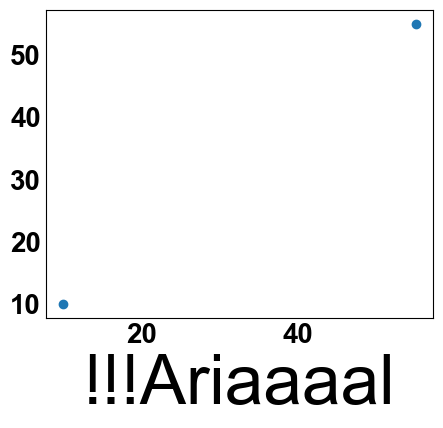

In [4]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [2]:
""" reading and preprocessing data"""
with open('./../data/trainingsets/60000_train_regular_pubqc/image_train.pickle', 'rb') as f:
    X_smiles_train0, SMILES_train0, y_train00 = pickle.load(f)
    
with open('./../data/trainingsets/60000_train_regular_pubqc/image_test.pickle', 'rb') as f:
    X_smiles_val0, SMILES_val0, y_val00 = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '



print (X_smiles_train0.shape)
print (X_smiles_val0.shape)

(106101, 40, 27, 1)
(24819, 40, 27, 1)


In [3]:
with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer_object.pickle', 'rb') as f:
    tokenizer_ = pickle.load(f)

In [5]:
tokenizer

{1: 'C',
 2: 'c',
 3: '(',
 4: ')',
 5: '1',
 6: 'O',
 7: '=',
 8: '.',
 9: 'N',
 10: '2',
 11: '[',
 12: ']',
 13: 'n',
 14: '3',
 15: 'H',
 16: 'S',
 17: '-',
 18: '#',
 19: '+',
 20: 's',
 21: 'o',
 22: 'P',
 23: 'F',
 24: '4',
 25: 'l',
 26: 'p',
 0: ' '}

In [8]:
# reduce the number of samples
# subsampling
idx = np.random.choice(len(y_train00), int(len(y_train00) * 1), replace = False)

X_smiles_train, SMILES_train, y_train0 = (X_smiles_train0[idx], SMILES_train0[idx], y_train00[idx])


idx = np.random.choice(len(y_val00), int(len(y_val00) * 1), replace = False)

X_smiles_val, SMILES_val, y_val0 = (X_smiles_val0[idx], SMILES_val0[idx], y_val00[idx])

print (X_smiles_train.shape)
print (X_smiles_val.shape)

(106101, 40, 27, 1)
(24819, 40, 27, 1)


In [11]:
print (max(y_train00))
print (min(y_val0))

10.985
1.148


In [10]:
# Standardized between 0 and 11
gap_min = 0
gap_max = 11
y_val   = (y_val0 -   gap_min) / (gap_max - gap_min)
y_train = (y_train0 - gap_min) / (gap_max - gap_min)

print (max(y_val))
print (max(y_train))

0.9779090909090908
0.9986363636363635


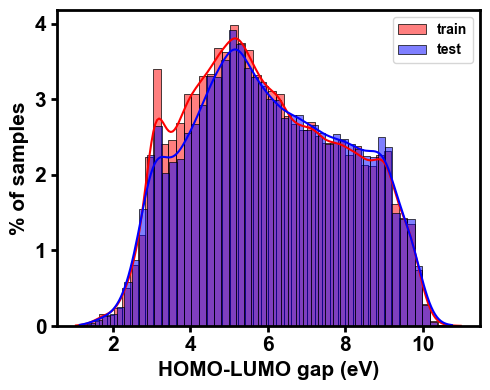

In [12]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.tick_params(axis='both', length=4, width=2, colors='black', grid_alpha=0, labelsize=15)
[i.set_linewidth(2) for i in ax.spines.values()]
plt.xlabel('HOMO-LUMO gap (eV)', fontname='Arial', fontweight = 'bold', fontsize=15)
plt.ylabel('% of samples', fontname='Arial', fontweight = 'bold', fontsize=15)

sns.histplot (y_train0, color='red', label='train', stat='percent', kde=True, bins=50)
sns.histplot (y_val0, color='blue', label='test', stat='percent', kde=True, bins=50, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('gap_test_train.jpeg', dpi=500)

In [14]:
""" models definition and extracting pretrained encoder and decoder """
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')

class Config:
    
    def __init__(self):
        self.Filters = [256, 128, 64]
        self.genFilters = [128, 128, 128]
        self.upFilters = [(2, 2), (2, 2), (2, 2)]
        
config = Config()

## Generator 
z = Input(shape = (128, ))
y = Input(shape = (1, ))

h = Concatenate(axis = 1)([z, y])
h = Dense(1 * 1 * 128)(h)
R1 = Reshape([1, 1, 128])(h)
R2 = Reshape([1, 1, 128])(h)

for i in range(3):
    R1 = UpSampling2D(size = config.upFilters[i])(R1)
    C1 = Conv2D(filters = config.genFilters[i], 
               kernel_size = 2, 
               strides = 1, 
               padding = 'same')(R1)
    B1 = BatchNormalization()(C1)
    R1 = LeakyReLU(alpha=0.2)(B1)

for i in range(3):
    R2 = UpSampling2D(size = config.upFilters[i])(R2)
    C2 = Conv2D(filters = config.genFilters[i], 
               kernel_size = 2, 
               strides = 1, 
               padding = 'same')(R2)
    B2 = BatchNormalization()(C2)
    R2 = LeakyReLU(alpha=0.2)(B2)
    
R1 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh')(R1)
R2 = Conv2D(1,
            kernel_size = 3,
            strides = 1,
            padding = 'valid',
            activation = 'tanh')(R2)

generator = Model([z, y], [R1, R2])
print (generator.summary())

## Discriminator 
inp1 = Input(shape = [6, 6, 1])
inp2 = Input(shape = [6, 6, 1])

X1 = Concatenate()([inp1, inp2])
X = Flatten()(X1)
y2 = Concatenate(axis = 1)([X, y])
for i in range(3):
		y2 = Dense(64, activation = 'relu')(y2)
		y2 = LeakyReLU(alpha = 0.2)(y2)
		y2 = Dropout(0.2)(y2)

O_dis = Dense(1, activation = 'sigmoid')(y2)


discriminator = Model([inp1, inp2, y], O_dis)
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 5e-5, beta_1 = 0.5))
print (discriminator.summary()) 

## Regressor
inp1 = Input(shape = [6, 6, 1])
inp2 = Input(shape = [6, 6, 1])

yr = Concatenate()([inp1, inp2])

tower0 = Conv2D(64, 1, padding = 'same')(yr)
tower1 = Conv2D(64, 1, padding = 'same')(yr)
tower1 = Conv2D(64, 3, padding = 'same')(tower1)
tower2 = Conv2D(32, 1, padding = 'same')(yr)
tower2 = Conv2D(32, 5, padding = 'same')(tower2)
tower3 = MaxPooling2D(3, 1, padding = 'same')(yr)
tower3 = Conv2D(32, 1, padding = 'same')(tower3)
h = Concatenate()([tower0, tower1, tower2, tower3])
h = ReLU()(h)
h = MaxPooling2D(2, 1, padding = 'same')(h)

for i in range(6):
    tower0 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 3, padding = 'same')(tower1)
    tower2 = Conv2D(32, 1, padding = 'same')(h)
    tower2 = Conv2D(32, 5, padding = 'same')(tower2)
    tower3 = MaxPooling2D(3, 1, padding = 'same')(h)
    tower3 = Conv2D(32, 1, padding = 'same')(tower3)
    h = Concatenate()([tower0, tower1, tower2, tower3])
    h = ReLU()(h)
    if i % 2 == 0 and i != 0:
        h = MaxPooling2D(2, 1, padding = 'same')(h)
h = BatchNormalization()(h)

yr = Flatten()(h)
o = Dropout(0.2)(yr)
o = Dense(128)(o)

o_reg = Dropout(0.2)(o)
o_reg = Dense(1, activation = 'sigmoid')(o_reg)

regressor = Model([inp1, inp2], o_reg)
regressor_top = Model([inp1, inp2], o)

2023-05-12 16:20:02.092219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-12 16:20:02.092400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-12 16:20:02.092463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-12 16:20:02.092662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-12 16:20:02.092731: I tensorflow/compiler/xla/stream_executo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 129)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          16640       ['concatenate[0][0]']        

None
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 6, 1)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 6, 6, 1)]    0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 6, 6, 2)      0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 72)           0           ['concatenate_1[0][0]'

In [12]:
# Training the Regressor 
# latent vectors from trained Encoder, 
# last output of Encoder is concat. (O1, O2)
train_atoms_embedding, train_bonds_embedding, _ = encoder.predict([X_smiles_train], verbose=0)
atoms_embedding, bonds_embedding, _ = encoder.predict([X_smiles_train], verbose=0)
atoms_val, bonds_val, _ = encoder.predict([X_smiles_val], verbose=0)

# No training if the trained model is saved. 
try:
    regressor = load_model('./../data/nns/keep/regressor.h5')
    regressor_top = load_model('./../data/nns/keep/regressor_top.h5')
    regressor.compile(loss = 'mse', optimizer = Adam(5e-7))
    print (".h5 was read")
except:
    print ("no .h5 available")
    regressor.compile(loss = 'mse', optimizer = Adam(5e-7))
    pass
    
history = regressor.fit([atoms_embedding, bonds_embedding], 
              y_train,
              validation_data = ([atoms_val,
                                  bonds_val],
                                 y_val),
              batch_size = 128,
              epochs = 1,
              verbose = 1)
    
# Validating the regressor
# Train
pred_train = regressor.predict([atoms_embedding, bonds_embedding])
pred_train0 = pred_train*(gap_max-gap_min)+gap_min
print('Current R2 on Regressor for train data: {}'.format(r2_score(y_train0, pred_train0.reshape([-1]))))
mse_train = mean_squared_error(y_train0, pred_train0.reshape([-1]))
mae_train = mean_absolute_error(y_train0, pred_train0.reshape([-1]))

#print ('prediction on train: ', pred_train)
#print ('True train: ', y_train)

# Test
pred = regressor.predict([atoms_val, bonds_val])
pred0 = pred*(gap_max-gap_min) + gap_min
print('Current R2 on Regressor for test data: {}'.format(r2_score(y_val0, pred0.reshape([-1]))))
mse_test = mean_squared_error (y_val0, pred0.reshape([-1]))
mae_test = mean_absolute_error (y_val0, pred0.reshape([-1]))

#print ("prediction on test: ", pred )
#print ("True test values: ", y_val)

print ('Train MSE: {}, RMSE: {}, MAE: {}'.format (round(mse_train, 5), 
                                                  round(mse_train**0.5, 5), 
                                                  round(mae_train, 5)))
print ('Test MSE: {}, RMSE: {}, MAE: {}'.format (round(mse_test, 5), 
                                                  round(mse_test**0.5, 5), 
                                                  round(mae_test, 5)))
# Saving the currently trained models
regressor.save('./../data/nns/regressor.h5')
regressor_top.save('./../data/nns/regressor_top.h5')

# save the losses 
with open ('regressor_loss_0_150.csv', 'w') as f:
    for key in history.history.keys():
        f.write("%s,%s\n"%(key,history.history[key]))

2023-05-11 13:10:19.574096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-11 13:10:19.968326: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


.h5 was read


2023-05-11 13:10:33.368458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-11 13:10:33.370063: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1e5d6210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-11 13:10:33.370076: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-11 13:10:33.373133: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-11 13:10:33.412632: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-11 13:10:33.436151: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once f

3316/3316 [==============================] - 6s 2ms/step
Current R2 on Regressor for train data: 0.9543672670405123
776/776 [==============================] - 1s 2ms/step
Current R2 on Regressor for test data: 0.9315370364630006
Train MSE: 0.17712, RMSE: 0.42086, MAE: 0.32163
Test MSE: 0.26537, RMSE: 0.51514, MAE: 0.38278


In [15]:
print (np.max(pred0))
print (np.max(y_train0))
print (np.max(pred_train0))
print (np.max(y_val0))


NameError: name 'pred0' is not defined

In [ ]:
MAE_pred_des = np.round (mean_absolute_error(pred0, y_val0), 4)
print ("MAE_pred_des", MAE_pred_des)
# Fractioned MAE, more normalized
Fractioned_MAE_pred_des = 0
for pred, true in zip(pred0, y_val0):
        Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(pred-true)/true
Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/(pred0.shape[0])
print ("MAEF_pred_des", Fractioned_MAE_pred_des)

MAE_pred_des 0.3828
MAEF_pred_des [0.07647]


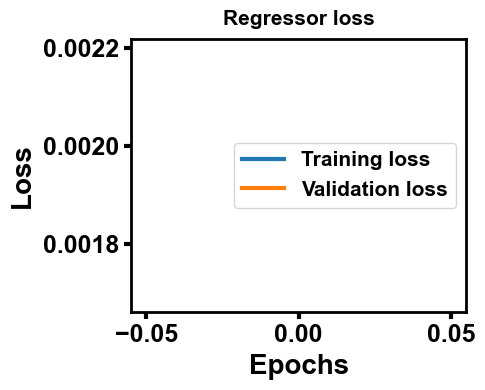

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(list(range(len(history.history['loss']))), 
         history.history['loss'], label='Training loss', linewidth=3,) 
plt.plot(list(range(len(history.history['val_loss']))), 
         history.history['val_loss'], label='Validation loss', linewidth=3,) 

ax.set_xlabel('Epochs', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('Loss', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=1, labelsize='18')

[i.set_linewidth(2) for i in ax.spines.values()]


#plt.title ('per {}, rand {}'.format(per, rand))

#plt.ylim(0, 12)
#plt.xticks((1, 3, 5, 7, 9,  11));
#plt.yticks((1, 3, 5, 7, 9,  11));
plt.title('Regressor loss', fontsize=15, fontname='Arial', fontweight='bold', pad=10)
plt.legend(fontsize=15) 
plt.tight_layout()
plt.savefig("R_loss_0_100.png", dpi=300)

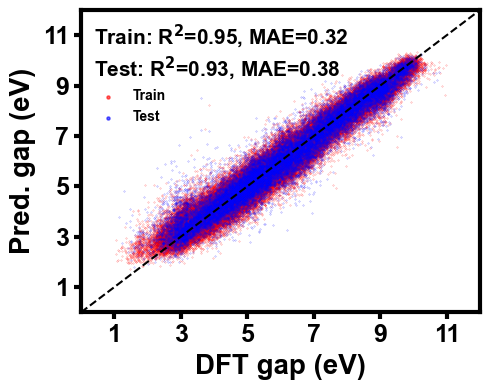

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.rcParams["legend.markerscale"] = 10
plt.scatter (y_train0, pred_train0, color='red', label='Train', alpha=0.6, s=0.05)
plt.scatter ( y_val0, pred0, color='blue', label='Test', alpha=0.6, s=0.05)

plt.legend()

ax.set_xlabel('DFT gap (eV)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('Pred. gap (eV)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black', 
               grid_alpha=1, labelsize='18')

[i.set_linewidth(3) for i in ax.spines.values()]
leg = plt.legend(title='Train: R$^2$={}, MAE={} \nTest: R$^2$={}, MAE={}'.\
           format(round(r2_score(y_train0, pred_train0.reshape([-1])), 2), 
                  round (mae_train, 2),
                  round (r2_score(y_val0, pred0.reshape([-1])), 2), 
                  round (mae_test, 2), ), framealpha=0, title_fontsize=15)
leg._legend_box.align = "left"

#plt.title ('per {}, rand {}'.format(per, rand))
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.xticks((1, 3, 5, 7, 9,  11));
plt.yticks((1, 3, 5, 7, 9,  11));
plt.plot([0, 12], [0, 12], '--k', )#color='black')
plt.tight_layout()
plt.savefig('regressor_train_test.jpeg', dpi=300)
plt.rcParams["legend.markerscale"] = 1

In [ ]:
np.max(pred_train0)

10.321617

In [ ]:
K.clear_session()

In [14]:
## Combined model 
def build_combined(z, y,
                   regressor,
                   regressor_top,
                   discriminator,
                   encoder,
                   decoder):
    discriminator.trainable = False
    regressor_top.trainable = False
    regressor.trainable = False
    encoder.trainable = False
    decoder.trainable = False
    
    atoms_emb, bonds_emb = generator([z, y])
    dec_embedding = Concatenate()([atoms_emb, bonds_emb])
    
    softmax_smiles, _ = decoder([dec_embedding])
    argmax_smiles = argmax (softmax_smiles, axis=2)
    argmax_smiles = Reshape([40])(argmax_smiles)
    smiles = one_hot(argmax_smiles, depth=27)
    smiles = Reshape([40, 27, 1])(smiles)
    latent_encoder_atom, latent_encoder_bond, _ = encoder ([smiles])
    
    y_pred = regressor([latent_encoder_atom, latent_encoder_bond])
    valid = discriminator([atoms_emb, bonds_emb, y])
    #print ('valid from comb', valid)

    combined = Model([z, y], [valid, y_pred])

    combined.compile(loss = ['binary_crossentropy',
                             'mse'], 
                     loss_weights = [0.01, 25.0], 
                     optimizer = Adam(5e-6, beta_1 = 0.5))
    
    return combined

combined = build_combined(z, y,
                          regressor,
                          regressor_top,
                          discriminator,
                          encoder,
                          decoder)

====
Current epoch: 1/200
D Loss Real: 0.3467157745130972
D Loss Fake: 0.026667885950222108
D Loss: 0.18669183023165967
G Loss: 1.3057123245536417
R Loss: 0.0016870553937632644
====

CCCCCC1CN1CC1CC1CCCNOCCO
gap_des [0.42211818]
error 0.58541
CCCC(CCCNN=O)C1CN1
gap_des [0.06169091]
error 0.94187
C=NCCCCCCCCC
gap_des [0.17487273]
error 0.7122
C#CCC(CC)CON1C=C1C
gap_des [0.66192727]
error 0.14156
CCC1CCNCCNC1NN1CCCCC1
gap_des [0.10682727]
error 0.97714
COCC(CCOO)OO
gap_des [0.30042727]
error 0.43496
CC1(N)CCNCCCNC1C1=CNC=CN1
gap_des [0.05837273]
error 0.90528
NC=CNCNCC1[C]CN1
gap_des [0.05579091]
error 0.65695
COCCCCC1OCCC(C)C(OCCCCOCO)CO1
gap_des [0.21370909]
error 1.05644
CCC(N)NC=CCCCNC(C)CNC
gap_des [0.79374545]
error 0.38787
ONCCCC1CCCCCCNN1O
gap_des [0.82731818]
error 0.22421
NCC1COC(N(O)OOO)OCC(=O)N1
gap_des [0.26632727]
error 0.70168
NNC(O)CCN(NN)NO
gap_des [0.99084545]
error 0.61321
C.CC(NN)NN(NN)NCCCCCCCCN
gap_des [0.4615]
error 0.29206
CC1=NC=C(Cl)CSC=CN1
gap_des [0.14527273]


2023-05-11 23:16:46.196435: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


====
Current epoch: 156/200
D Loss Real: 0.5382650932971982
D Loss Fake: 0.22919143332339428
D Loss: 0.38372826331029625
G Loss: 0.5127719925077641
R Loss: 0.0014798171851437556
====

CC(C)CCCC(O)=CC1C(C)C1O
gap_des [0.32576364]
error 0.54056
CCCC=C=CCC(C)(CO)CCCC
gap_des [0.51327273]
error 0.19278
CC1CCCC(CN(C)O)OC1O
gap_des [0.8058]
error 0.05993
COCC(NCCO)C1CN(C)C1
gap_des [0.28631818]
error 0.74641
CCC1COCC(C)OC(C(C)COC)C1
gap_des [0.85108182]
error 0.18459
COCC(CCO)OOCNCOC(O)CNOC
gap_des [0.64521818]
error 0.13754
CCCCCC(OCC)C(C)(CCO)OC
gap_des [0.41036364]
error 0.66678
C=CC(CN)NC1CSNN1SCC
gap_des [0.10537273]
error 0.70019
CCC1=CC(C)=CC=CNC(C)CNNCC1
gap_des [0.34005455]
error 0.25696
CCCCCCC1CCCCCC(CC)CCCCC1
gap_des [0.91421818]
error 0.40852
CCCCCC(C)CC1CCCCC1C(C)CCCCC
gap_des [0.96546364]
error 0.12481
CCC(C)C1CC(CC(C)C)C=C(C)C1CC
gap_des [0.70678182]
error 0.06753
COC(O)C(C)C=C(C)NCC(C)O
gap_des [0.8955]
error 0.53642
CC1=C2CC(=CO)C=C(C=N1)C2
gap_des [0.41945455]
error 0.0427

Done


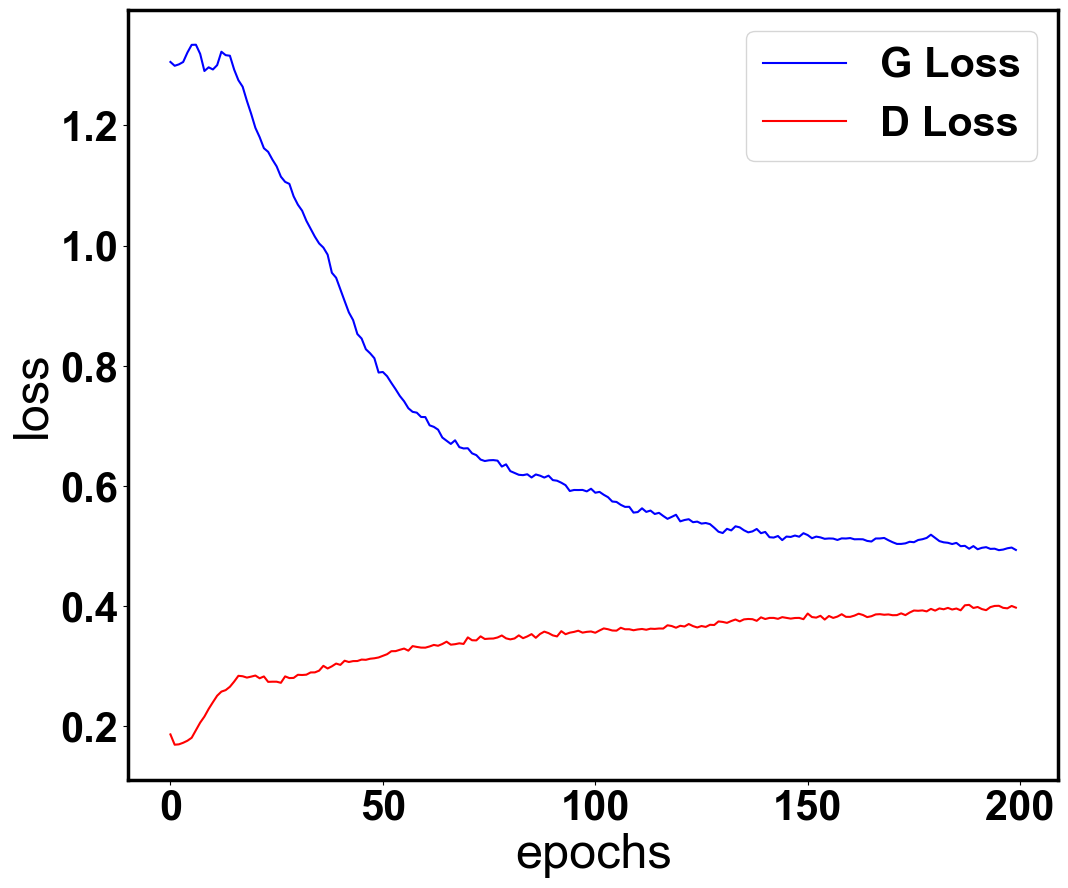

In [15]:
p = multiprocessing.Process()
""" Training RCGAN """
# loading pretrained models
regressor = load_model    ('./../data/nns/regressor.h5')
regressor_top = load_model('./../data/nns/regressor_top.h5')
#generator = load_model    ('./../data/nns/keep/generator.h5')
#discriminator = load_model ('./../data/nns/keep/discriminator.h5')
#combined = load_model ('./../data/nns/combined.h5')

regressor_top.trainable = False
regressor.trainable = False

# SMILES related information
max_gen_atoms = 9
bond_max = 9
MAX_NB_WORDS = 27
MAX_SEQUENCE_LENGTH = 40


epochs = 200
batch_size = 256
batches = y_train0.shape[0] // batch_size
threshold = 0.1 # defining accurate samples
reinforce_n = 50 # 5*reinforce_n = fake sampling
reinforce_sample = 1000 # how many samples generated for Reinforcement

# variable for storing generated data
G_Losses = []
D_Losses = []
R_Losses = []
D_Losses_real = []
D_Losses_fake = []

for e in range(epochs):
    start = time.time()
    D_loss = []
    G_loss = []
    R_loss = []
    D_loss_real = []
    D_loss_fake = []
    
    for b in range(batches):
        
        regressor_top.trainable = False
        regressor.trainable = False

        idx = np.arange(b * batch_size, (b + 1) * batch_size)
        # rearrange the samples 
        idx = np.random.choice(idx, batch_size, replace = False)
        
        x_smiles_train = X_smiles_train[idx] 
        batch_y = y_train[idx]
        
        batch_z = np.random.normal(0, 1, size = (batch_size, 128))
        
        atoms_embedding, bonds_embedding, _ = encoder.predict([x_smiles_train], verbose=0)
        dec_embedding = np.concatenate([atoms_embedding, bonds_embedding], axis = -1)
        
        gen_atoms_embedding, gen_bonds_embedding = generator.predict([batch_z, batch_y], verbose=0)
        
        gen_dec_embedding = np.concatenate([gen_atoms_embedding, gen_bonds_embedding], axis = -1)
        softmax_smiles = decoder.predict(gen_dec_embedding, verbose=0)[0]
        
        argmax_smiles = np.argmax(softmax_smiles, axis = 2)
        smiles = to_categorical(argmax_smiles, num_classes=27)
        SHAPE = list(smiles.shape) + [1]
        smiles = smiles.reshape(SHAPE)
        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
        gen_pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
        
        regressor.trainable = True
        r_loss = regressor.train_on_batch([atoms_embedding, bonds_embedding], batch_y)
        R_loss.append(r_loss)
        regressor.trainable = False

        discriminator.trainable = True
        # original was 3!
        d = 3
        #if b<100:
        #    d=1
        for _ in range(d):
            d_loss_real = discriminator.train_on_batch([atoms_embedding, bonds_embedding, batch_y],
                                                       [0.9 * np.ones((batch_size, 1))])
            d_loss_fake = discriminator.train_on_batch([gen_atoms_embedding, gen_bonds_embedding, batch_y],
                                                       [np.zeros((batch_size, 1))]) 

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        D_loss.append(d_loss)
        D_loss_real.append (d_loss_real)
        D_loss_fake.append (d_loss_fake)
        discriminator.trainable = False
        
        regressor_top.trainable = False
        regressor.trainable = False

        #for _ in range(d):
        g_loss = combined.train_on_batch([batch_z, batch_y], [0.9 * np.ones((batch_size, 1)), batch_y])
        
        G_loss.append(g_loss[0])
    
    D_Losses.append(np.mean(D_loss))
    D_Losses_real.append(np.mean(D_loss_real))
    D_Losses_fake.append(np.mean(D_loss_fake))
    G_Losses.append(np.mean(G_loss))
    R_Losses.append(np.mean(R_loss))
    
    print('====')
    print('Current epoch: {}/{}'.format((e + 1), epochs))
    print ('D Loss Real: {}'.format(np.mean(D_loss_real)))
    print ('D Loss Fake: {}'.format(np.mean(D_loss_fake)))
    print('D Loss: {}'.format(np.mean(D_loss)))
    print('G Loss: {}'.format(np.mean(G_loss)))
    print('R Loss: {}'.format(np.mean(R_loss)))
    print('====')
    print()

    
    # Reinforcement
    gen_error = []
    gen_smiles = []
    gen_valid_smiles = []
    gen_X_atoms = []
    gen_X_bonds = []
    predcv_AE_latent = []
    embeddings = []
    sample_ys = []
    valid_smiles_index = []
    for _ in range(reinforce_sample):
        sample_y = np.random.uniform(gap_min, gap_max, size = [1, ])
        sample_y = np.round(sample_y, 4)
        sample_y = (sample_y - gap_min) / (gap_max - gap_min)
        sample_ys.append(sample_y)

        sample_z = np.random.normal(0, 1, size = (1, 128))

        sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y], verbose=0)
        embeddings.append((sample_atoms_embedding, sample_bonds_embedding))
        
        dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)
        softmax_smiles = decoder.predict(dec_embedding, verbose=0)[0]
        argmax_smiles = np.argmax(softmax_smiles, axis = 2).reshape([-1])
        smiles = to_categorical(argmax_smiles, num_classes=27)
        SHAPE = [1] + list(smiles.shape) + [1]
        smiles = smiles.reshape(SHAPE)
        c_smiles = ''
        for s in argmax_smiles:
            c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
        
        gen_smiles.append(c_smiles)
        latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
        reg_pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0)
        
        pred, desire = reg_pred[0][0], sample_y[0]
        gen_error.append(round (np.abs((pred - desire) / (6/11)), 5)) #!!!!!!!!!!!!! chenge it to desire

        
    gen_error = np.asarray(gen_error)
    # two validity defined: 

    # without sanitizing: valid 0    
    valid = 0
    valid0 = 0
    idx_ = []
    idx0_ = []
    for iter_, smiles in enumerate(gen_smiles):
        if ' ' in smiles[:-1]:
            continue
        m  = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
        m0 = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
        if m0 is not None:
            valid0 += 1
            idx0_.append(iter_)
        if m is not None:
            #if len(construct_atomic_number_array(m)) <= 60:
            valid += 1
            idx_.append(iter_)
            try:
                gen_smiles [iter_] = Chem.MolToSmiles(m, canonical=True)
                print (Chem.MolToSmiles(m, canonical=True))
                print ("gap_des", sample_ys[iter_])
                print ("error", gen_error[iter_])
            except:
                pass
    idx_ = np.asarray(idx_)
    idx0_ = np.asarray(idx0_)

    validity = [gen_smiles[jj] for jj in idx0_ ]
    validity = pd.DataFrame(validity)
    validity = validity.drop_duplicates()

    validity_sanitize = [gen_smiles[jj] for jj in idx_ ]
    validity_sanitize = pd.DataFrame(validity_sanitize)
    validity_sanitize = validity_sanitize.drop_duplicates()

    if (e + 1) % 100 == 0:
        reinforce_n += 10

    # invalid smiles:
    fake_indices1 = np.setdiff1d(np.arange(reinforce_sample), np.asarray(idx_))
    fake_indices2 = np.intersect1d(np.where(gen_error > threshold)[0], idx_)
    fake_indices = np.concatenate ((fake_indices1, fake_indices2))
    fake_indices = np.random.choice(fake_indices, reinforce_n * 5, replace = False)

    real_indices_ = np.intersect1d(np.where(gen_error <= threshold)[0], idx_)
    sample_size =  len(real_indices_)
    real_indices = np.random.choice(real_indices_, sample_size, replace = False)
    
    # Activating Reinforcement 
    if e >= 5:
        discriminator.trainable = True
        regressor_top.trainable = False
        regressor.trainable = False
        for real_index in real_indices:
            #real_latent = regressor_top.predict([embeddings[real_index][0], embeddings[real_index][1]])
            _ = discriminator.train_on_batch([embeddings[real_index][0], 
                                              embeddings[real_index][1], 
                                              sample_ys[real_index]],
                                             [1 * np.ones((1, 1))])

        for fake_index in fake_indices:
            #fake_latent = regressor_top.predict([embeddings[fake_index][0], embeddings[fake_index][1]])
            _ = discriminator.train_on_batch([embeddings[fake_index][0], 
                                              embeddings[fake_index][1] , 
                                              sample_ys[fake_index]],
                                             [np.zeros((1, 1))])
        discriminator.trainable = False

    # ==== #
    try:
        print('Currently valid SMILES (No chemical_beauty and sanitize off): {}'.format(valid0))
        print('Currently valid SMILES Unique (No chemical_beauty and sanitize off): {}'.format(len(validity)))
        print('Currently valid SMILES Sanitized: {}'.format(valid))
        print('Currently valid Unique SMILES Sanitized: {}'.format(len(validity_sanitize)))
        print('Currently satisfying SMILES: {}'.format(len(real_indices_)))
        print('Currently unique satisfying generation: {}'.format(len(np.unique(np.array(gen_smiles)[real_indices_]))))
        #print('Gen Sample is: {}, for {}'.format(c_smiles, sample_y))
        #print('Predicted val: {}'.format(reg_pred))
        print('====')
        print()
    except:
        pass
    
    if (e + 1) % 5 == 0:
        plt.close()
        fig, ax = plt.subplots(figsize = (12, 10))
        ax.tick_params(axis='both', which='major', labelsize=30)
        plt.plot(G_Losses, color='blue')
        plt.plot(D_Losses, color='red')
        plt.xlabel('epochs', fontsize=35)
        plt.ylabel('loss', fontsize=35)
        mpl.rcParams['axes.linewidth'] = 2.5
        #plt.plot(R_Losses)
        plt.legend(['G Loss', 'D Loss'], fontsize=30)
        plt.savefig("G_D_losses{}.png".format (e+1))
    

    n_unique = len(np.unique(np.array(gen_smiles)[real_indices_]))
    n_valid = valid
    if valid > 450 and n_unique > 350:
        print('Criteria has satisified, training has ended')
        break

    end = time.time()
    print ("time for current epoch: ", (end - start))

    tf.compat.v1.keras.backend.clear_session()
with open('GAN_loss.pickle', 'wb') as f:
    pickle.dump((G_Losses, D_Losses, R_Losses), f)

# Saving the currently trained models
#regressor.save('regressor.h5')
#regressor_top.save('regressor_top.h5')
generator.save('./../data/nns/generator.h5')
discriminator.save('./../data/nns/discriminator.h5')
combined.save('./../data/nns/combined.h5')

p.start()

p.join()
print ('Done')

In [13]:
tf.compat.v1.keras.backend.clear_session()

In [57]:
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')
model = load_model('./../data/nns/keep/ae_model.h5')

regressor = load_model    ('./../data/nns/keep/regressor.h5')
regressor_top = load_model('./../data/nns/keep/regressor_top.h5')
generator = load_model    ('./../data/nns/keep/generator.h5')
discriminator= load_model ('./../data/nns/keep/discriminator.h5')

pbar = ProgressBar()
max = 0.3

randS = []
rsquaredS = []
MAE_S = []
less20RE_perS = []
output_lenS = []
mean_RE_S = []
for rand in pbar(range (7, 8)):  
    N = 50
    n_sample = 100
    gen_error = []
    gen_smiles = []
    sample_ys = []
    preds = []
  
    predss_can = []
    gen_atoms_embedding = []
    gen_bonds_embedding = []

    regressor_top.trainable = False
    regressor.trainable = False
    generator.trainable = False
    discriminator.trainable = False

    np.random.seed(rand)

    pbar = ProgressBar()
    samples = np.random.uniform(0, 10.7, size=[150, ])
    for hc in (pbar(samples)):
        try:
            # get it back to original of s_min to s_max
            #sample_y = np.random.uniform(0, 10.7, size=[1,])
            sample_y = hc
            #print (sample_y)
            sample_y = np.round(sample_y, 4)
            sample_y = sample_y * np.ones([N, ])
            sample_y_ = (sample_y - gap_min) / (gap_max - gap_min)
            sample_z = np.random.normal(0, 1, size = (N, 128))

            regressor_top.trainable = False
            regressor.trainable = False
            encoder.trainable = False
            decoder.trainable = False

            sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y_], verbose=0)
            dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)

            softmax_smiles = decoder.predict(dec_embedding, verbose=0)[0]
            argmax_smiles = np.argmax(softmax_smiles, axis = 2)
            #print (argmax_smiles)

            #print ('shape argmax_smiles', argmax_smiles.shape)
            smiles = to_categorical(argmax_smiles, num_classes=27)
            
            SHAPE = list(smiles.shape) + [1] 
            
            #print ('shape line 767', SHAPE) 
            smiles = smiles.reshape(SHAPE)

            latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
            pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
            pred = pred * (gap_max - gap_min) + gap_min

            gen_errors = np.abs((pred - sample_y) / sample_y).reshape([-1])


            smiles = decoder.predict(dec_embedding, verbose=0)[0]
            #print(smiles)
            smiles = np.argmax(smiles, axis = 2).reshape(smiles.shape[0], 40)
            

            generated_smiles = []
            
            for S in smiles:
                c_smiles = ''
                for s in S:
                    c_smiles += tokenizer[s]
                c_smiles = c_smiles.rstrip()
                #print (c_smiles)
                generated_smiles.append(c_smiles)
            generated_smiles = np.array(generated_smiles)
            #generated_smiles = generated_smiles [accurate]
            all_gen_smiles = []
            idx = []
            preds_can = []
            for i, smiles in enumerate(generated_smiles):
                all_gen_smiles.append(smiles[:-1])

                if ' ' in smiles[:-1]:
                    continue
                #m = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
                m = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
                if m is not None:
                    idx.append(i)
                    smiles_can = Chem.MolToSmiles(m, canonical=True)
                    smiles_can_dot = smiles_can + '.'
                    X_smiles0 = tokenizer_.texts_to_sequences([smiles_can_dot])
                    X_smiles1 = pad_sequences(X_smiles0, maxlen = 40, padding = 'post')
                    X_smiles2 = to_categorical(X_smiles1, num_classes=27)
                    latent_encoder_atom, latent_encoder_bond, _ = encoder.predict(X_smiles2, verbose=0)
                    pred_can = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
                    pred_can = pred_can*11
                    preds_can.append(pred_can[0])


            idx = np.array(idx)
            all_gen_smiles = np.array(all_gen_smiles)
            #print ('all gen smiels shape', all_gen_smiles.shape)
            #print ('gen_errors shape', gen_errors.shape)
            #print (idx)
            gen_smiles.extend(list(all_gen_smiles[idx]))
            gen_error.extend(list(gen_errors[idx]))
            sample_ys.extend(list(sample_y[idx]))
            gen_atoms_embedding.extend(sample_atoms_embedding[idx])
            gen_bonds_embedding.extend(sample_bonds_embedding[idx])
            preds.extend(list(pred[idx]))
            predss_can.extend(list(preds_can))
        except:
            #print('Did not discover SMILES for HC: {}'.format(sample_y))
            pass    


    output = {}

    for i, s in enumerate (gen_smiles):
        ss = Chem.MolToSmiles(Chem.MolFromSmiles(s, sanitize=True), canonical=True)
        gen_smiles[i] = ss

    output['SMILES'] = gen_smiles
    output['des_gap'] = sample_ys
    # More accurate for regressor to predict gap from canonical SMILES
    output['pred_gap'] = predss_can
    #output['Err_pred_des'] = gen_error
    output['Err_pred_des'] = [abs(i- j)/i for i, j in zip(output['des_gap'], output['pred_gap'])]
    output = pd.DataFrame(output)
    output.reset_index(drop = True, inplace = True)
    output.to_csv ('./../experiments/regular/Initial_training.csv', index=False)

    ## Statistics  (# pred=True value, Des=prediction)
    # total # of samples
    N = len(predss_can)
    print ('random seed', rand)

    # Explained Variance R2 from sklearn.metrics.explained_variance_score
    explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
    print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
    rsquared = np.round (r2_score (output['des_gap'], output['pred_gap']), 4)
    print ("r squared r**2", rsquared)

    # mean absolute error 
    MAE_pred_des = np.round (mean_absolute_error(output['pred_gap'], output['des_gap']), 4)
    print ("MAE_pred_des", MAE_pred_des)
    # Fractioned MAE, more normalized
    Fractioned_MAE_pred_des = 0
    for pred, des in zip(output['pred_gap'], output['des_gap']):
        Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(des-pred)/des
    Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/N
    #print ("Fractioned MAE_pred_des", Fractioned_MAE_pred_des)

    # root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
    RMSE_pred_des = mean_squared_error(output['pred_gap'], output['des_gap'])**0.5
    #print ("RMSE_pred_des", RMSE_pred_des)

    Fractioned_RMSE_pred_des = 0
    for pred, des in zip(output['pred_gap'], output['des_gap']):
        Fractioned_RMSE_pred_des = Fractioned_RMSE_pred_des + ((des-pred)/des)**2
    Fractioned_RMSE_pred_des = (Fractioned_RMSE_pred_des/N)**0.5
    #print ("Fractioned_RMSE_pred_des", Fractioned_RMSE_pred_des)

    # do not drop duplicate
    output2 = output.drop_duplicates(['SMILES'])
    output2.reset_index(drop = True, inplace = True)
    output2.to_csv('./../experiments/regular/Initial_training_nodub.csv', index = False)
    """with open('gen_pickles.pickle', 'wb') as f:
        pickle.dump(gen_unique_pickles, f)
    """
    #print ('% < 20 RE NODUP', sum (output2['Err_pred_des'] < 0.2) / output2['Err_pred_des'].shape[0])
    less20RE_per = np.round ((sum(output['Err_pred_des'] <= 0.2) / output['Err_pred_des'].shape[0]), 4)
    print ('% < 20 RE', less20RE_per)
    output_len = len(output)
    explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
    #print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
    mean_RE = np.round (np.mean (output['Err_pred_des']), 4)
    print ('RE mean', mean_RE)

    randS.append(rand)
    rsquaredS.append(rsquared)
    MAE_S.append(MAE_pred_des)
    less20RE_perS.append(less20RE_per)
    mean_RE_S.append(mean_RE)
    output_lenS.append(output_len)

    if rsquared>max:
        good_rand = rand
        max = rsquared
        best_r2 = rsquared
        print ('best r2', best_r2)
        print ('best random seed', good_rand)
    
    tf.compat.v1.keras.backend.clear_session()

params = {}
params ['rand'] = randS
params ['r2'] = rsquaredS
params ['MAE'] = MAE_S
params ['less20RE_per'] = less20RE_perS
params ['Average_RE'] = mean_RE_S
params ['total_valid'] = output_lenS
params = pd.DataFrame(params)
params.reset_index(drop = True, inplace = True)
params.to_csv ('./gen_params.csv', index=False)

100% |########################################################################|


random seed 7
explained_varice_R2_pred_des 0.45220128970753204
r squared r**2 0.4521
MAE_pred_des 1.2469
% < 20 RE 0.6369
RE mean 0.22
best r2 0.4521
best random seed 7


In [61]:
output_screen = output.loc[output['Err_pred_des']<0.8]
less20RE_per = np.round ((sum(output_screen['Err_pred_des'] < 0.2) / output_screen['Err_pred_des'].shape[0]), 4)
less20RE_per

0.6667

In [62]:
output['RE_pred_mean'] = [abs(i-j)/6 for i,j in zip(output['pred_gap'], output['des_gap'])]

<Axes: xlabel='RE_pred_mean', ylabel='Count'>

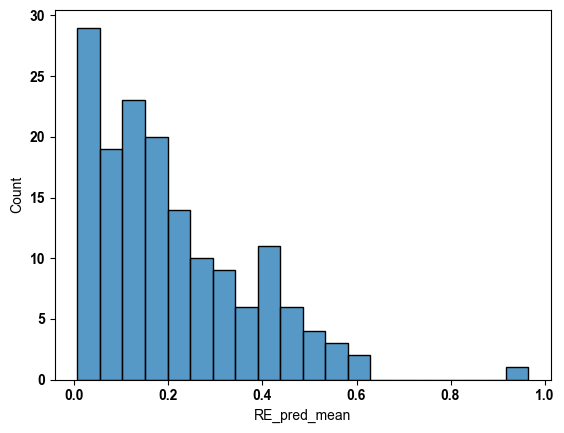

In [63]:
sns.histplot (output['RE_pred_mean'], bins=20)

In [64]:
try:
    print ('best r2', best_r2)
    print ('best random seed', good_rand)
except:
    pass

best r2 0.4521
best random seed 7


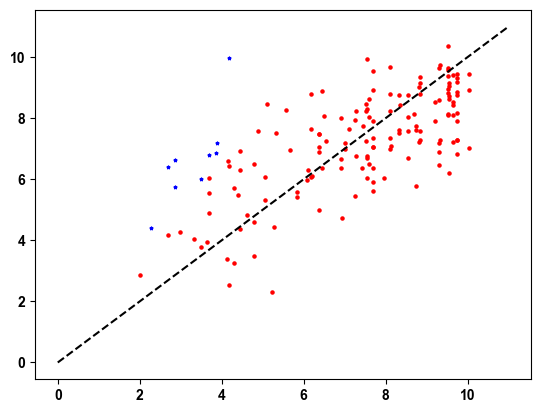

In [65]:
plt.scatter (output['des_gap'].loc[output['Err_pred_des']<=0.7], output['pred_gap'].loc[output['Err_pred_des']<=0.7], s=5, color='red')
plt.scatter (output['des_gap'].loc[output['Err_pred_des']>0.7], output['pred_gap'].loc[output['Err_pred_des']>0.7], s=5, marker='*', color='blue')
#sns.scatterplot (x='des_gap', y='pred_gap', palette='Reds', s=15, edgecolor=None, data=output.loc[output['Err_pred_des']<0.7])
plt.plot([0, 11], [0, 11], '--k', )

<Axes: xlabel='pred_gap', ylabel='Percent'>

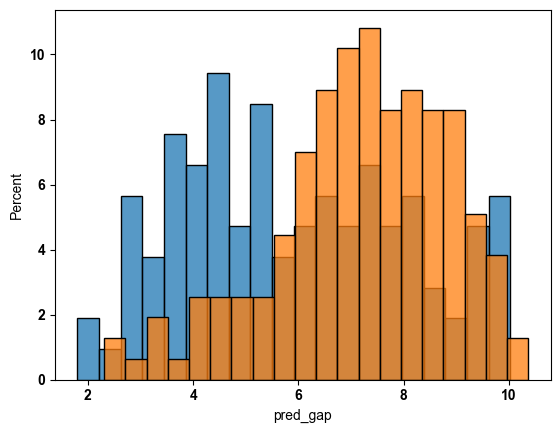

In [66]:
sns.histplot (samples, stat='percent', bins=20)
sns.histplot (output['pred_gap'], stat='percent', bins=20)